In [95]:
import json
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import numpy as np

np.random.seed(48)

We will import the two main CSVs containing the kibana and metric logs which we will use in further analysis.

In [96]:
kibana = pd.read_csv("kibana.csv")
print("Example kibana log data:\n ")
print(kibana.iloc[0])
print("\nShape of kibana data: "+str(kibana.shape))

Example kibana log data:
 
score                                                           5.0232
type                                                               log
id                                                AXCbMDhAQp1MinEMcxcx
index                                             indy-logs-2020.03.02
thread                                                  XNIO-2 task-12
level                                                            DEBUG
timestamp                                                1583151592248
@timestamp                                    2020-03-02T12:19:53.254Z
context                                                        default
message              BASIC authenticate injector checking for Autho...
pipeline_metadata                             2020-03-02T12:19:53.254Z
version                                                              1
logger               org.commonjava.indy.bind.jaxrs.keycloak.BasicA...
BUILD_COMMIT                  8c867041ff881386dc30

In [97]:
metrics = pd.read_csv("metric_df.csv")
print("Example metrics log data:\n ")
print(metrics.iloc[0])
print("\nShape: "+str(metrics.shape))

Example metrics log data:
 
infinispan.pool.ConnectivityCheck_healthy                                          True
o.c.i.m.healthcheck.impl.DeadlockHealthCheck_healthy                               True
o.c.i.m.healthcheck.impl.HeapHealthCheck_healthy                                   True
o.c.i.m.healthcheck.impl.HeapHealthCheck_free-gb                                16.1449
o.c.i.m.healthcheck.impl.HeapHealthCheck_used-gb                                1.85508
                                                                              ...      
weft.ThreadPoolExecutor.store-validation.store-validation_healthy                  True
weft.ThreadPoolExecutor.store-validation.store-validation_pool-size                   2
weft.ThreadPoolExecutor.store-validation.store-validation_current-load                0
weft.ThreadPoolExecutor.store-validation.store-validation_load-factor                 0
timestamp                                                                 1583146199151
Name

c:\users\schub\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (85,89,97,101,105,113,121,129,133,137,141,145,149) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


final_cols_kibana and final_cols_metrics will contain the columns for their respective logs that we will later feed to the ML model.

In [98]:
# Set the columns to train the model on
final_cols_kibana = ['id','thread','level','timestamp','@timestamp','message','logger','POD_NAME']
final_cols_metrics = ['o.c.i.m.healthcheck.impl.HeapHealthCheck_used-gb', 'sli.golden.content.listing_latency', 'sli.golden.content.listing_errors', 'sli.golden.content.listing_throughput', 'sli.golden.content.maven_throughput', 'sli.golden.maven.download_latency', 'sli.golden.maven.download_throughput', 'sli.golden.maven.upload_latency', 'sli.golden.repo.mgmt_latency', 'sli.golden.repo.mgmt_throughput', 'weft.ThreadPoolExecutor.galley-transfers.galley-transfers_current-load', 'weft.ThreadPoolExecutor.indy-event-dispatch.indy-event-dispatch_current-load', 'weft.ThreadPoolExecutor.koji-metadata.koji-metadata_current-load', 'weft.ThreadPoolExecutor.maven-metadata-generator.maven-metadata-generator_current-load', 'weft.ThreadPoolExecutor.promote-validation-rules-executor.promote-validation-rules-executor_current-load', 'weft.ThreadPoolExecutor.promote-validation-rules-runner.promote-validation-rules-runner_current-load', 'weft.ThreadPoolExecutor.promotion-transfers.promotion-transfers_current-load', 'weft.ThreadPoolExecutor.promotion.promotion_current-load', 'timestamp']

In [99]:
k_logs = kibana[final_cols_kibana] 
m_logs = metrics[final_cols_metrics]
print("Shape of final kibana logs: "+str(k_logs.shape))
print("Shape of final metrics logs: "+str(m_logs.shape))

Shape of final kibana logs: (38000, 8)
Shape of final metrics logs: (95000, 19)


We now merge directly on the 'timestamp' field to check how many records have an exact match for their timestamps.

In [100]:
print(pd.merge(k_logs, m_logs, left_on='timestamp',right_on='timestamp').shape[0])

22


With only 22 records out of a total of 38,000 having an actual match, we instead will have to resort to using pd.merge_asof which will merge the kibana logs with the metric data having the closest value in the timestamps past.

In [101]:
k_logs.sort_values('timestamp', inplace=True)
m_logs.sort_values('timestamp', inplace=True)

df = pd.merge_asof(k_logs,m_logs,left_on='timestamp',right_on='timestamp')

print("Shape on merging kibana and metrics logs: " + str(df.shape))


Shape on merging kibana and metrics logs: (38000, 26)


c:\users\schub\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\schub\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [102]:
#k_logs[(~k_logs.timestamp.isin(df.timestamp))]
# Above would otherwise print every row in the metrics dataframe which the above merge missed out

We graph the correlation between all of the numerical data fields using a heatmap. 

We note that most of the columns have relatively low correlation with each other and hence don't contain minimum redundant information.

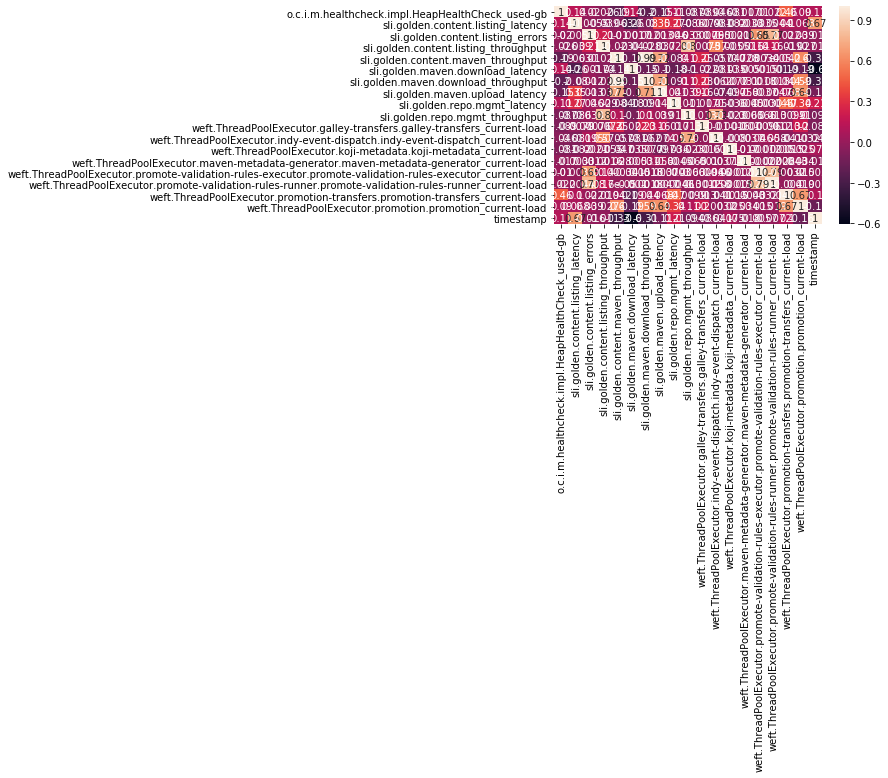

In [103]:
sns.heatmap(df[final_cols_metrics].corr(),annot=True)
plt.show()

In this section we will check the resultant dataframe for null or missing values. Since these missing values would cause a problem for the clustering algorithm we will deal with them by dropping rows that contain missing fields.

In [104]:
#Right now we will just drop rows with null values. 
#TODO: consider filling with values from the previous metric row or even median values..


#print(df.isnull().sum())
#df.dropna(axis = 0, inplace = True)
#print("Shape on dropping nulls: " + str(df.shape))

'''Shape on dropping nulls: (31606, 26)'''

'Shape on dropping nulls: (31606, 26)'

Although dropping all rows with any null values is commonly observed, the number of rows that we lose in the dataset is roughly 15% of all the data we started out with. Thus it might be better that we try to to retain this data. Two possible ways would be to either impute the value from other columns in the same record OR we could simply fill in with the value from a previously or later observed record.

The first method is far more complicated because not only do we have to build a model to infer the missing values which itself might be prone to error, our analysis also showed that many of the rows have multiple values missing in different fields which makes this approach rather problematic.

So we will instead use the approach of filling in with the last observed reading. While simpler, this allows us to take advantage of the fact that we are working with time-series data and we will work with the assumption if a current value is missing, we consider it to not have changed since the last observed reading.

In [105]:
df.fillna(method="ffill", inplace=True)
print("Shape on forward-filling nulls: " + str(df.shape))

Shape on forward-filling nulls: (38000, 26)


We know look at the basic statistics of the columns that we will be using in our model:

In [106]:
df.describe()

,timestamp,o.c.i.m.healthcheck.impl.HeapHealthCheck_used-gb,sli.golden.content.listing_latency,sli.golden.content.listing_errors,sli.golden.content.listing_throughput,sli.golden.content.maven_throughput,sli.golden.maven.download_latency,sli.golden.maven.download_throughput,sli.golden.maven.upload_latency,sli.golden.repo.mgmt_latency,sli.golden.repo.mgmt_throughput,weft.ThreadPoolExecutor.galley-transfers.galley-transfers_current-load,weft.ThreadPoolExecutor.indy-event-dispatch.indy-event-dispatch_current-load,weft.ThreadPoolExecutor.koji-metadata.koji-metadata_current-load,weft.ThreadPoolExecutor.maven-metadata-generator.maven-metadata-generator_current-load,weft.ThreadPoolExecutor.promote-validation-rules-executor.promote-validation-rules-executor_current-load,weft.ThreadPoolExecutor.promote-validation-rules-runner.promote-validation-rules-runner_current-load,weft.ThreadPoolExecutor.promotion-transfers.promotion-transfers_current-load,weft.ThreadPoolExecutor.promotion.promotion_current-load
count,3.800000e+04,38000.000000,3.800000e+04,3.800000e+04,3.800000e+04,3.800000e+04,3.800000e+04,3.800000e+04,3.800000e+04,3.800000e+04,3.800000e+04,38000.000000,38000.000000,38000.000000,38000.000000,38000.000000,38000.000000,38000.000000,38000.000000
mean,1.583177e+12,1.777933,1.665293e+08,1.996572e-06,1.497675e-04,1.167828e+00,8.351337e+09,1.089702e+00,1.315255e+08,7.687230e+07,2.664034e-03,0.012053,0.045605,12.826132,0.239737,0.011211,0.000105,0.719763,0.228289
std,2.796059e+07,0.659241,2.004133e+08,9.231281e-05,2.313306e-03,2.434136e+00,1.248864e+10,2.150484e+00,1.311754e+08,1.981294e+08,1.195244e-02,0.109122,0.359755,134.276877,8.193603,1.375874,0.010259,1.968332,0.419736
min,1.583150e+12,0.227881,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.583152e+12,1.299228,5.496401e+07,1.630875e-145,5.436743e-84,2.574637e-55,1.170892e+08,2.531773e-07,6.264474e+07,9.045545e+06,2.244565e-57,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.583168e+12,1.973619,7.597657e+07,3.203404e-58,1.281362e-57,7.975487e-41,5.610231e+08,1.534484e-02,7.160954e+07,1.489352e+07,8.216456e-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.583202e+12,2.029794,1.636813e+08,2.727342e-28,5.311474e-18,6.148872e-02,9.431131e+09,7.091754e-01,1.904684e+08,7.972905e+07,9.625462e-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.583235e+12,4.918088,6.171574e+08,7.553669e-03,4.797335e-02,8.715573e+00,3.060964e+10,8.170744e+00,5.353406e+08,1.500382e+09,2.053274e-01,1.000000,6.000000,1513.000000,438.000000,188.000000,1.000000,8.000000,1.000000


Since algorithms dont deal directly with categorical fields we must remove these columns before passing the data to the ML model. We select all these columns by selecting them by their datatype 'object' and dropping all these columns from the final data.

Additionally we will even drop the timestamp data as we dont want the time of the event to be a factor in clustering.

We run the data through StandardScaler() which normalises the data so that the different ranges of all the numerical fields dont hinder the clustering algorithm.


In [107]:
obj_cols = df.select_dtypes(object).columns
data = df.drop(obj_cols,axis=1)
data = data.drop('timestamp',axis=1)

scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

## Isolation Forest
We train an isolation forest model for the preprocessed data. In this model 'outlier_fraction_forest' will be the expected ratio of anomalies in the data.

In [108]:
outlier_fraction_forest = 0.01

model_forest =  IsolationForest(contamination=outlier_fraction_forest, random_state = 48)
model_forest.fit(data)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=48, verbose=0, warm_start=False)

### Graphing the resuls of isolation forest

In [109]:
errors = df.loc[df['level'] == "ERROR", ['timestamp', 'sli.golden.content.listing_latency']] #ERROR logs
warns = df.loc[df['level'] == "WARN", ['timestamp', 'sli.golden.content.listing_latency']] #WARN logs

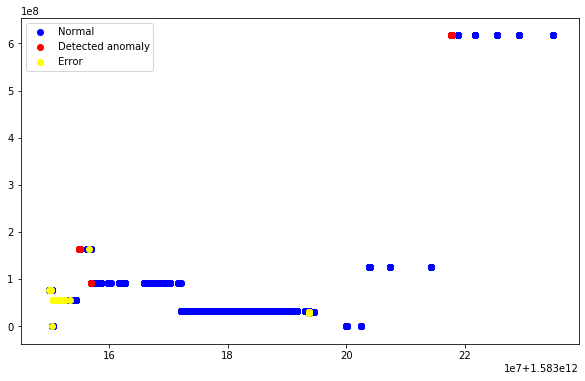

In [110]:
df['anomaly'] = pd.Series(model_forest.predict(data))

#df.to_csv('results.csv',index=False) writing anomalies to file for later analysis

fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly'] == -1, ['timestamp', 'sli.golden.content.listing_latency']] #anomaly

ax.scatter(df['timestamp'], df['sli.golden.content.listing_latency'], color='blue', label = 'Normal')
ax.scatter(a['timestamp'],a['sli.golden.content.listing_latency'], color='red', label = 'Detected anomaly')
ax.scatter(errors['timestamp'],errors['sli.golden.content.listing_latency'], color='yellow', label = 'Error')
#ax.scatter(warns['timestamp'],warns['sli.golden.content.listing_latency'], color='orange', label = 'Warning')
plt.legend()
plt.show();

In [111]:
print("Number of anomalies found: " + str(df.loc[df.anomaly==-1].shape[0]))

Number of anomalies found: 375


## One Class SVM for anomaly detection

In [112]:
outlier_fraction_svm = 0.01

model_SVM = OneClassSVM(nu= outlier_fraction_svm, kernel="rbf")
model_SVM.fit(data)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.01, shrinking=True, tol=0.001, verbose=False)

### Graphing the results of One Class SVM

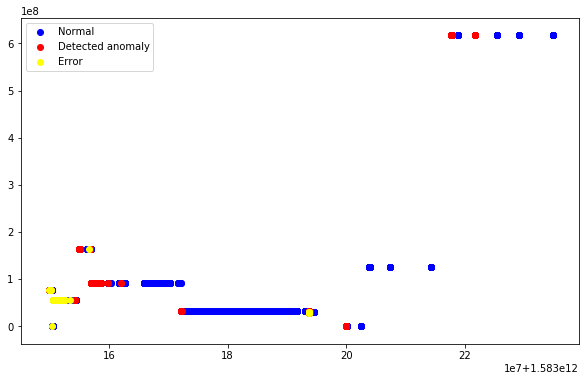

In [113]:
df['anomaly_svm'] = pd.Series(model_SVM.predict(data))

fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly_svm'] == -1, ['timestamp', 'sli.golden.content.listing_latency']] #anomaly

ax.scatter(df['timestamp'], df['sli.golden.content.listing_latency'], color='blue', label = 'Normal')
ax.scatter(a['timestamp'],a['sli.golden.content.listing_latency'], color='red', label = 'Detected anomaly')
ax.scatter(errors['timestamp'],errors['sli.golden.content.listing_latency'], color='yellow', label = 'Error')
#ax.scatter(warns['timestamp'],warns['sli.golden.content.listing_latency'], color='orange', label = 'Warning')
plt.legend()
plt.show();

# Running anomaly detection for all the data

While earlier we ran the algorithm only for the merged data, we will now run the algorithm on all of the metrics data instead.

This gives a more complete idea of the anomalies present in the operations of the environment

In [114]:
#metric_data = metrics[final_cols_metrics].drop("timestamp",axis=1).dropna(axis = 0)
#print("Shape after dropping nulls:" + str(metric_data.shape))
'''Shape after dropping nulls:(81652, 19)'''

'Shape after dropping nulls:(81652, 19)'

In [115]:
# Similarly forward filling instead of dropping nulls
metric_data = metrics[final_cols_metrics].drop("timestamp",axis=1).fillna(method="ffill")
print("Shape after filling nulls:" + str(metric_data.shape))

Shape after filling nulls:(95000, 18)


In [116]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(metric_data)
metric_data = pd.DataFrame(np_scaled)

In [117]:
model_forest_metrics =  IsolationForest(contamination=outlier_fraction_forest)
model_forest_metrics.fit(metric_data)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [118]:
final_cols_metrics.append('anomaly')

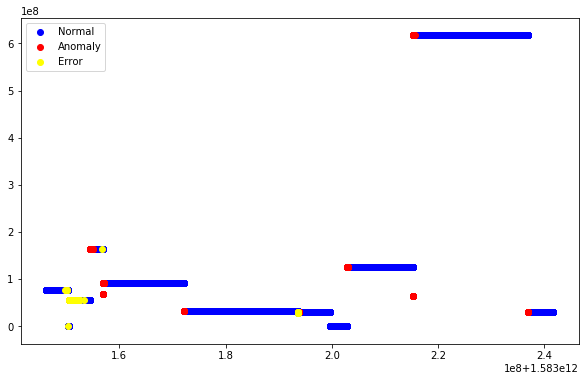

In [119]:
metrics['anomaly'] = pd.Series(model_forest_metrics.predict(metric_data))

#metrics[final_cols_metrics].to_csv('results_metrics.csv',index=False) # write anomalies of all the data for analysis

fig, ax = plt.subplots(figsize=(10,6))

a = metrics.loc[metrics['anomaly'] == -1, ['timestamp', 'sli.golden.content.listing_latency']] #anomaly

ax.scatter(metrics['timestamp'], metrics['sli.golden.content.listing_latency'], color='blue', label = 'Normal')
ax.scatter(a['timestamp'],a['sli.golden.content.listing_latency'], color='red', label = 'Anomaly')
ax.scatter(errors['timestamp'],errors['sli.golden.content.listing_latency'], color='yellow', label = 'Error')
#ax.scatter(warns['timestamp'],warns['sli.golden.content.listing_latency'], color='orange', label = 'Warning')
plt.legend()
plt.show();